<a href="https://colab.research.google.com/github/dp-IED/FinalYearProject/blob/main/ODB2_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-rpwuol61/granite-tsfm_6341d579f0a944ce964fe5ac492b4789
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-rpwuol61/granite-tsfm_6341d579f0a944ce964fe5ac492b4789
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Install bitsandbytes
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 13.6 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import Trainer, TrainingArguments, set_seed
import torch


from tsfm_public import TimeSeriesPreprocessor, get_datasets
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public.toolkit.visualization import plot_predictions

import warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

print("="*70)
print("MULTI-SESSION VEHICLE FORECASTING WITH TTM")
print("="*70)

MULTI-SESSION VEHICLE FORECASTING WITH TTM


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = "/content/drive/MyDrive/ODB2 FYP/combined_obd_dataset_watsonx.csv"
print(f"\nLoading combined dataset from: {dataset_path}")
data = pd.read_csv(dataset_path, parse_dates=["timestamp"])


Loading combined dataset from: /content/drive/MyDrive/ODB2 FYP/combined_obd_dataset_watsonx.csv


In [6]:
print(f"✓ Loaded: {len(data):,} total samples")
print(f"✓ Columns: {len(data.columns)}")

# Preview
print(f"\nDataset preview:")
print(data[['timestamp', 'source_file', 'original_row_id', 'Vehicle Speed Sensor [km/h]']].head(10))

✓ Loaded: 2,693,087 total samples
✓ Columns: 23

Dataset preview:
                timestamp                         source_file  \
0 2017-07-05 07:16:31.257  2017-07-05_Seat_Leon_RT_S_Stau.csv   
1 2017-07-05 07:16:31.345  2017-07-05_Seat_Leon_RT_S_Stau.csv   
2 2017-07-05 07:16:31.435  2017-07-05_Seat_Leon_RT_S_Stau.csv   
3 2017-07-05 07:16:31.525  2017-07-05_Seat_Leon_RT_S_Stau.csv   
4 2017-07-05 07:16:31.615  2017-07-05_Seat_Leon_RT_S_Stau.csv   
5 2017-07-05 07:16:31.705  2017-07-05_Seat_Leon_RT_S_Stau.csv   
6 2017-07-05 07:16:31.795  2017-07-05_Seat_Leon_RT_S_Stau.csv   
7 2017-07-05 07:16:31.886  2017-07-05_Seat_Leon_RT_S_Stau.csv   
8 2017-07-05 07:16:31.975  2017-07-05_Seat_Leon_RT_S_Stau.csv   
9 2017-07-05 07:16:32.065  2017-07-05_Seat_Leon_RT_S_Stau.csv   

   original_row_id  Vehicle Speed Sensor [km/h]  
0                0                          0.0  
1                1                          0.0  
2                2                          0.0  
3                3

In [7]:
## 2. Choose Which Columns to Track

target_columns = [
    "Vehicle Speed Sensor [km/h]",
    "Engine RPM [RPM]",
]

print(f"\n✓ Tracking {len(target_columns)} columns:")
for col in target_columns:
    print(f"    - {col}")

## 3. Add Numeric Session ID for TTM
# Create a numeric session_id from source_file
# TTM works better with numeric IDs since it treats each recorded session separately
source_files = data['source_file'].unique()
file_to_id = {file: idx for idx, file in enumerate(source_files)}
data['session_id'] = data['source_file'].map(file_to_id)

print(f"\n✓ Created session_id mapping:")
print(f"  Total sessions: {data['session_id'].nunique()}")
print(f"  Example: '{source_files[0]}' → session_id = 0")


✓ Tracking 2 columns:
    - Vehicle Speed Sensor [km/h]
    - Engine RPM [RPM]

✓ Created session_id mapping:
  Total sessions: 81
  Example: '2017-07-05_Seat_Leon_RT_S_Stau.csv' → session_id = 0



Visualizing sample sessions...
✓ Sample sessions plot saved to plots/sample_sessions.png


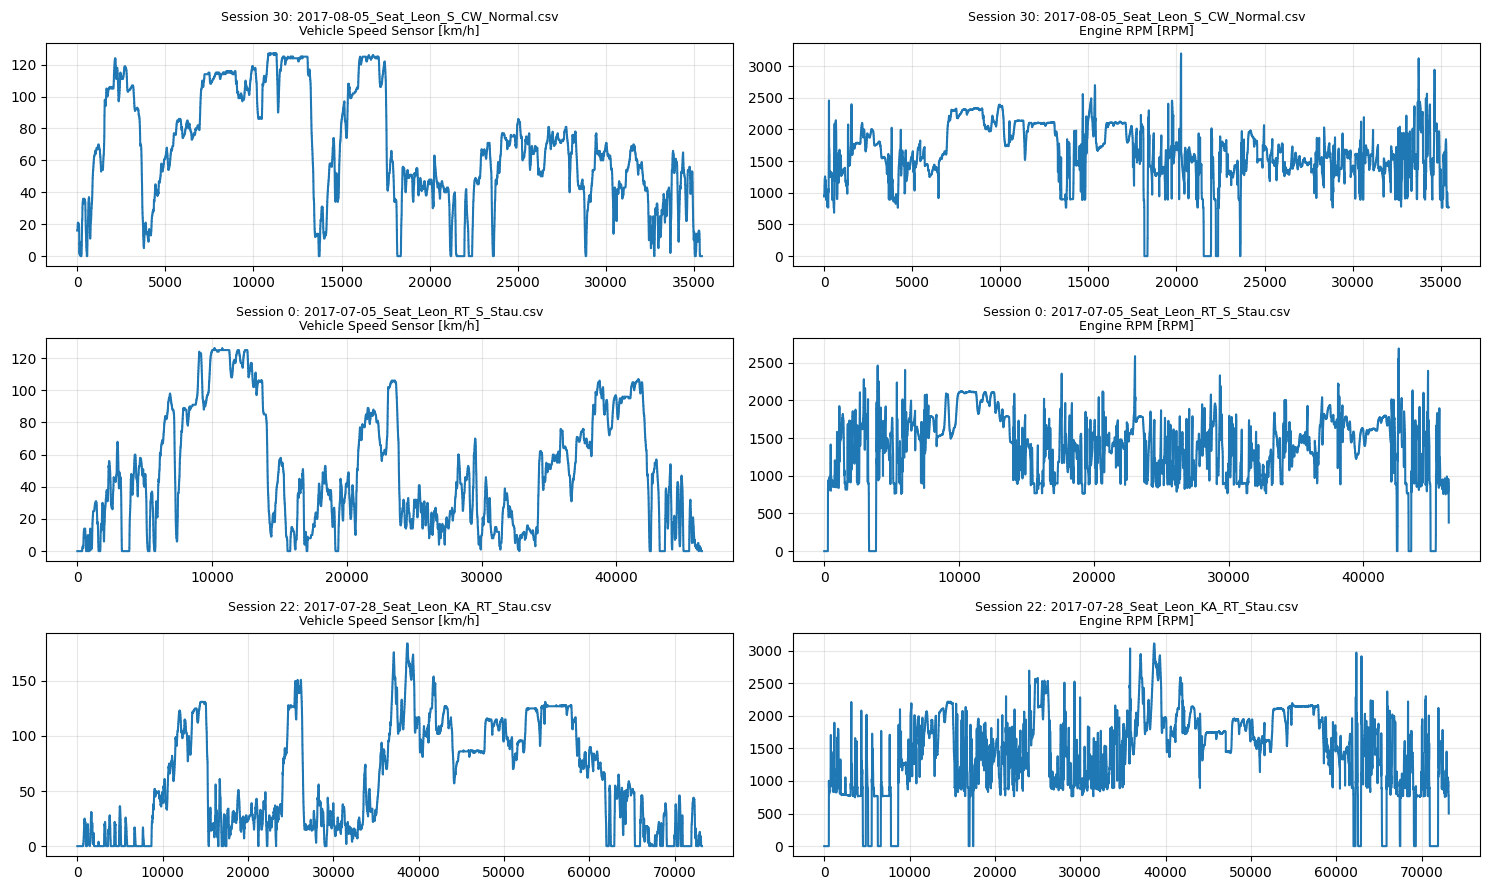

In [8]:
## 4. Visualize Sample Sessions

# Define the directory and filename
dir_path = 'plots'
file_name = 'sample_sessions.png'
full_path = os.path.join(dir_path, file_name)

# Create the directory if it does not exist
os.makedirs(dir_path, exist_ok=True)


print("\nVisualizing sample sessions...")
num_sessions_to_plot = 3
np.random.seed(SEED)
sample_session_ids = np.random.choice(data['session_id'].unique(), num_sessions_to_plot, replace=False)

fig, axes = plt.subplots(num_sessions_to_plot, len(target_columns), figsize=(15, 3*num_sessions_to_plot))

if num_sessions_to_plot == 1:
    axes = axes.reshape(1, -1)

for row, sess_id in enumerate(sample_session_ids):
    session_data = data[data['session_id'] == sess_id]
    session_name = session_data['source_file'].iloc[0]

    for col_idx, col in enumerate(target_columns):
        ax = axes[row, col_idx] if len(target_columns) > 1 else axes[row]
        ax.plot(session_data[col].values)
        ax.set_title(f'Session {sess_id}: {session_name}\n{col}', fontsize=9)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(full_path, dpi=150, bbox_inches='tight')
print(f"✓ Sample sessions plot saved to {full_path}")

In [9]:
## 5. Configure TTM with Multi-Series Support

# CRITICAL: Use session_id as the ID column
# This tells TTM that each session is a separate time series
timestamp_column = "timestamp"
id_columns = ["session_id"]  # ← This is the key!

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,  # TTM will respect session boundaries
    "target_columns": target_columns,
    "control_columns": [],
}

# Model configuration
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
print(f"\n{'='*70}")
print(f"MODEL CONFIGURATION")
print(f"{'='*70}")
print(f"Model: {TTM_MODEL_PATH}")
print(f"Context Length: {CONTEXT_LENGTH} time points")
print(f"Prediction Length: {PREDICTION_LENGTH} time points")
print(f"ID Column: {id_columns[0]} (ensures sessions don't mix)")


MODEL CONFIGURATION
Model: ibm-granite/granite-timeseries-ttm-r2
Context Length: 512 time points
Prediction Length: 96 time points
ID Column: session_id (ensures sessions don't mix)


In [11]:
## 6. Prepare Data

print(f"\nPreparing data...")

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

# Split configuration - splits WITHIN each session
# Each session gets split 70/15/15, but sessions never mix
split_config = {
    "train": [0, 0.7],     # First 70% of each session
    "valid": [0.7, 0.85],  # Next 15% of each session
    "test": [0.85, 1.0],   # Last 15% of each session
}

print("Loading pre-trained TTM model...")
model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH)

# Create datasets - samples from ALL sessions
print("Creating train/valid/test datasets...")
dset_train, dset_valid, dset_test = get_datasets(
    tsp,
    data,
    split_config,
    use_frequency_token=model.config.resolution_prefix_tuning
)

print(f"\n✓ Dataset sizes:")
print(f"    Train: {len(dset_train):,} samples")
print(f"    Valid: {len(dset_valid):,} samples")
print(f"    Test:  {len(dset_test):,} samples")

# Calculate samples per session (approximate)
avg_session_length = len(data) / data['session_id'].nunique()
approx_samples_per_session = (avg_session_length * 0.7 - CONTEXT_LENGTH) / PREDICTION_LENGTH
print(f"\n  Approx {approx_samples_per_session:.0f} training samples per session")
print(f"  From {data['session_id'].nunique()} sessions")


Preparing data...
Loading pre-trained TTM model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

Creating train/valid/test datasets...

✓ Dataset sizes:
    Train: 1,835,954 samples
    Valid: 396,267 samples
    Test:  396,309 samples

  Approx 237 training samples per session
  From 81 sessions


In [ ]:
## 7. Zero-Shot Evaluation

print(f"\n{'='*70}")
print(f"ZERO-SHOT EVALUATION (No Fine-Tuning)")
print(f"{'='*70}")

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./output",
        per_device_eval_batch_size=8,
        seed=SEED,
        report_to="none",
        # Add parameters to enable GPU usage
        no_cuda=False,  # Ensure CUDA is not disabled
        per_device_train_batch_size=8, # Add a training batch size for potential future fine-tuning
        dataloader_num_workers=2, # Add workers for data loading
    ),
)

print("Evaluating on test set...")
results = trainer.evaluate(dset_test)
print(f"\n✓ Test MSE: {results['eval_loss']:.4f}")


ZERO-SHOT EVALUATION (No Fine-Tuning)
Evaluating on test set...


In [ ]:
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting
import torch

zeroshot_model = model

zeroshot_forecast_pipeline = TimeSeriesForecastingPipeline(
    model=zeroshot_model,
    device="cuda" if torch.cuda.is_available() else "cpu",
    timestamp_column=timestamp_column,
    id_columns=id_columns, # Use the defined id_columns
    target_columns=target_columns,
    freq="100ms" # Updated frequency to 100ms
)

In [ ]:
zeroshot_forecast = zeroshot_forecast_pipeline(dset_test)

In [ ]:
# Compare actual vs predicted for each target column programmatically

comparison_results = {}
timestep_to_compare = 0 # You can change this timestep (0-indexed)

print(f"\nComparing actual vs predicted for each target column at timestep {timestep_to_compare}:")

# Ensure predictions_np is available (from trainer.predict in cell d62ed075-df4b-4967-bd90-074c3b0c86c0)
if 'predictions_np' not in locals():
    print("Error: 'predictions_np' not found. Please run the trainer.predict cell first.")
else:
    num_samples_test = len(dset_test)
    num_samples_predictions = predictions_np.shape[0]

    if num_samples_test != num_samples_predictions:
        print(f"Warning: The number of samples in dset_test ({num_samples_test}) does not match the number of samples in predictions_np ({num_samples_predictions}).")
        print("Comparison might be inaccurate.")

    for target_col_index, target_col_name in enumerate(target_columns):
        print(f"\nProcessing target column: {target_col_name}")

        comparisons = []

        # Iterate through the test dataset samples
        for i in range(min(num_samples_test, num_samples_predictions)):

            # Extract predicted value for the specified timestep and target column from predictions_np
            if timestep_to_compare < 0 or timestep_to_compare >= predictions_np.shape[1]:
                 print(f"Warning: Timestep {timestep_to_compare} is out of range for prediction length {predictions_np.shape[1]}. Skipping sample {i} for {target_col_name}.")
                 continue
            if target_col_index < 0 or target_col_index >= predictions_np.shape[2]:
                 print(f"Warning: Target column index {target_col_index} is out of range for predictions_np shape. Skipping sample {i} for {target_col_name}.")
                 continue


            predicted_value = predictions_np[i, timestep_to_compare, target_col_index]

            # Extract actual value from dset_test for the corresponding sample and timestep
            actual_values_for_sample = dset_test[i]['future_values'] # Shape (prediction_length, num_target_columns)

            if timestep_to_compare < 0 or timestep_to_compare >= actual_values_for_sample.shape[0]:
                 print(f"Warning: Timestep {timestep_to_compare} is out of range for actual values. Skipping sample {i} for {target_col_name}.")
                 continue
            if target_col_index < 0 or target_col_index >= actual_values_for_sample.shape[1]:
                 print(f"Warning: Target column index {target_col_index} is out of range for actual_values_for_sample shape. Skipping sample {i} for {target_col_name}.")
                 continue

            actual_value = actual_values_for_sample[timestep_to_compare][target_col_index]

            if i < len(zeroshot_forecast):
                 forecast_item_for_ts = zeroshot_forecast[i]
                 forecast_data_for_ts = forecast_item_for_ts['forecast']
                 if timestep_to_compare < len(forecast_data_for_ts):
                     actual_timestamp = pd.to_datetime(forecast_data_for_ts[timestep_to_compare]['timestamp'])
                 else:
                     actual_timestamp = None # Or reconstruct if necessary and possible
            else:
                actual_timestamp = None # Cannot get timestamp from zeroshot_forecast


            comparisons.append({
                'sample_index': i, # Add sample index for clarity
                'timestamp': actual_timestamp, # Use timestamp from forecast item if possible
                'actual': actual_value,
                'predicted': predicted_value
            })

        comparison_results[target_col_name] = pd.DataFrame(comparisons)

        # Display the head of the comparison DataFrame for the current column
        print(f"Comparison results for '{target_col_name}' at timestep {timestep_to_compare} (first 5 rows):")
        display(comparison_results[target_col_name].head())

    print("\nComparison complete using predictions from trainer.predict and actuals from dset_test.")

In [ ]:
zs_forecast.head()

In [ ]:
## 9. Analyze by Driving Condition

print(f"\n{'='*70}")
print(f"ANALYSIS BY DRIVING CONDITION")
print(f"{'='*70}")

# Extract condition from source_file
def extract_condition(filename):
    """Extract driving condition from filename"""
    if 'Stau' in filename:
        return 'Traffic Jam'
    elif 'Frei' in filename:
        return 'Free Flow'
    elif 'Normal' in filename:
        return 'Normal'
    elif 'Glatteis' in filename:
        return 'Ice'
    elif 'Vollbremsung' in filename:
        return 'Emergency Brake'
    else:
        return 'Other'

data['condition'] = data['source_file'].apply(extract_condition)

# Sessions by condition
condition_counts = data.groupby('condition')['session_id'].nunique()
print("\nSessions by condition:")
for condition, count in sorted(condition_counts.items(), key=lambda x: x[1], reverse=True):
    pct = 100 * count / data['session_id'].nunique()
    print(f"  {condition:20s}: {count:2d} sessions ({pct:.1f}%)")

# Speed statistics by condition
print("\nSpeed statistics by condition:")
speed_stats = data.groupby('condition')['Vehicle Speed Sensor [km/h]'].agg(['mean', 'std', 'max'])
print(speed_stats.round(2))

## 10. Summary

print(f"\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")
print(f"Dataset:")
print(f"  ✓ {len(data):,} total samples")
print(f"  ✓ {data['session_id'].nunique()} driving sessions")
print(f"  ✓ {len(target_columns)} tracked columns")
print(f"\nModel:")
print(f"  ✓ Context: {CONTEXT_LENGTH} points")
print(f"  ✓ Prediction: {PREDICTION_LENGTH} points")
print(f"  ✓ Sessions separated by ID column: '{id_columns[0]}'")
print(f"\nResults:")
print(f"  ✓ Train samples: {len(dset_train):,}")
print(f"  ✓ Valid samples: {len(dset_valid):,}")
print(f"  ✓ Test samples: {len(dset_test):,}")
print(f"  ✓ Zero-shot MSE: {results['eval_loss']:.4f}")
print(f"\nKey Feature:")
print(f"  • Model treats each of {data['session_id'].nunique()} sessions separately")
print(f"  • Samples NEVER cross session boundaries")
print(f"  • Learns patterns from diverse driving conditions")
print(f"\nNext Steps:")
print(f"  • Fine-tune the model on this dataset for better performance")
print(f"  • Evaluate performance per driving condition")
print(f"  • Try different context/prediction lengths")
print(f"  • Add more target columns to track")
print(f"{'='*70}")
